In [1]:
import importlib
import sys

import numpy as np

# Force reload to avoid stale objects
if 'symbolic_bounds' in sys.modules:
    for mod in list(sys.modules.keys()):
        if mod.startswith('symbolic_bounds'):
            del sys.modules[mod]

from symbolic_bounds import DAG, DataGenerator, SCM, ProgramFactory
from symbolic_bounds.random_dag_generator import generate_random_partitioned_dag
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

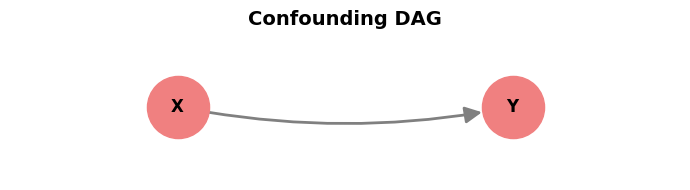

In [22]:
# 1. Generate a confounding DAG
dag = DAG()
X = dag.add_node('X', support={0, 1})
Y = dag.add_node('Y', support={0, 1})
# L0 = dag.add_node('L0', support={0, 1}, partition='L')
dag.add_edge(X, Y)

fig = dag.draw(figsize=(7, 2), title="Confounding DAG", with_labels=True)
plt.show()


In [23]:
dag.generate_all_response_types()
dag.print_response_type_table(X)
dag.print_response_type_table(Y)


Response types for X (no parents):
r_X^1: X = 0
r_X^2: X = 1


Response types for Y (parents: X):
=====

r_Y^1:
X | Y
-----
0 | 0
1 | 0

r_Y^2:
X | Y
-----
0 | 0
1 | 1

r_Y^3:
X | Y
-----
0 | 1
1 | 0

r_Y^4:
X | Y
-----
0 | 1
1 | 1



In [24]:
# 3. Generate Data
generator = DataGenerator(dag, seed=234)
joint = generator.computeObservedJoint() #Dict[FrozenSet[Tuple[Node, int]], float]
# p11 = joint.get(frozenset({(X, 1), (Y, 1)}))
# p10 = joint.get(frozenset({(X, 1), (Y, 0)}))
# generator.print_true_distribution()
# print(f'The known tian pearl bounds: [{p11:.4f}, {1-p10:.4f}] for P(Y=1 | do(X=1))')

In [ ]:
# 4. Create SCM
scm = SCM(dag, generator)

lp = ProgramFactory.write_LP(scm, Y={Y}, X={X}, Y_values=(1,), X_values=(1,))

lp.is_minimization = True
# lp.print_decision_variables()
# lp.print_objective()

lb = lp.solve(verbose=True).evaluate_objective(np.array([1]))

lp.is_minimization = False
ub = lp.solve(verbose=True).evaluate_objective(np.array([1]))
print(f"\nEstimated bounds for P(Y=1 | do(X=1)): [{lb:.6f}, {ub:.6f}]")

true_prob = generator.computeTrueIntervention(
    Y={Y}, 
    X={X}, 
    Y_values=(1,), 
    X_values=(1,)
)
print(f"True P(Y=1 | do(X=1)) = {true_prob:.6f}")

Building MPLP_Program:
  Variables: 8

Processing constraints (removing redundancies)...
Building MPLP_Program:
  Variables: 8

Processing constraints (removing redundancies)...

Estimated bounds for P(Y=1 | do(X=1)): [0.490918, 0.681848]
True P(Y=1 | do(X=1)) = 0.606769


C:\Users\tmari\AppData\Local\Temp\ipykernel_10204\2365645059.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{


,parameter,lb,ub,w,true_prob
0,0.01,0.490918,0.681848,0.19093,0.606769
1,0.02,0.490918,0.681848,0.19093,0.606769
2,0.03,0.490918,0.681848,0.19093,0.606769
3,0.04,0.490918,0.681848,0.19093,0.606769
4,0.05,0.490918,0.681848,0.19093,0.606769
...,...,...,...,...,...
76,0.77,0.490918,0.681848,0.19093,0.606769
77,0.78,0.490918,0.681848,0.19093,0.606769
78,0.79,0.490918,0.681848,0.19093,0.606769
79,0.80,0.490918,0.681848,0.19093,0.606769


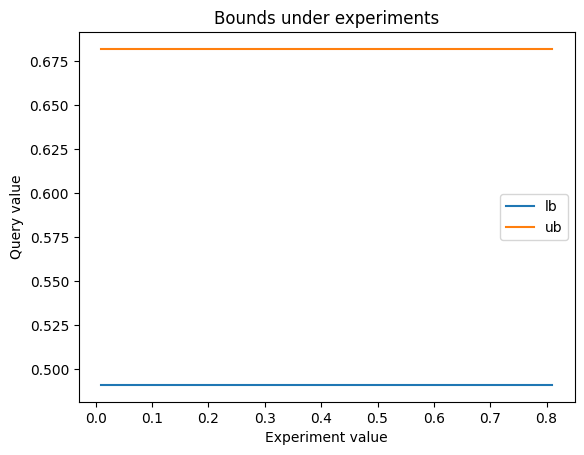

In [6]:
# Test with experimental constraints
lp_exp = ProgramFactory.write_LP(scm, Y={Y}, X={X}, Y_values=(1,), X_values=(1,),
                                  V={Y}, Z={X}, V_values=(0,), Z_values=(0,))

lp_exp.is_minimization = True
result_lb = lp_exp.solve(verbose=False)
lp_exp.is_minimization = False
result_ub = lp_exp.solve(verbose=False)

import pandas as pd
df = pd.DataFrame(columns=['parameter', 'lb','ub', 'w','true_prob'])
for p in range(0, 101):  # Loop from 0 to 100 inclusive
    parameter = p / 100  # Convert to step size of 0.01
    lb = result_lb.evaluate_objective(np.array([parameter]))
    ub = result_ub.evaluate_objective(np.array([parameter]))
    if lb is None or ub is None:
        continue
    df = pd.concat([df, pd.DataFrame([{
        'parameter': parameter,
        'lb': lb,
        'ub': ub,
        'w': ub-lb,
        'true_prob': true_prob
    }])], ignore_index=True)

df.plot(x='parameter', xlabel='Experiment value', y=['lb', 'ub'], ylabel='Query value', title='Bounds under experiments')

df